Build 3 models for flat price prediction:
    
- Price based on square meters number
- Price based on subway distance
- Price based on both square meters number and subway distance

For 1st and 2nd models draw both train data and predicted outputs. Compare real results with model outputs using all metrics from slides.

# Importing data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import operator

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn")

In [2]:
data = pd.read_excel("../data/flat_prices.xlsx", index_col="Id")
display(data)

,SQUARE_METERS,METRO_DISTANCE,PRICE
Id,,,
601,28,677,7328400
602,54,120,9754600
603,43,1344,6781500
604,33,1003,6784100
605,30,591,7296200
...,...,...,...
696,28,2073,4826700
697,63,2120,6800800
698,33,1411,6517500


# Theory 

Suppose we have $n$ instances of data with $m$ parameters and $n$ answers. The task is to build a linear function $f(x)$ that minimizes 
$$S=\sum _{i=1}^{n}({y_{i}-f(x_{i})})^{2}$$
This is called [least squares method](https://en.wikipedia.org/wiki/Least_squares).

So we have to find coefficents $\theta_i$ of $f(x) = \theta_0 + \theta_1x_1 + \ldots + \theta_mx_m$.

To do so, we should initialize matrix $n \times (m + 1)$:
$$X = 
\begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1m} & 1\\
x_{21} & x_{22} & \cdots & x_{2m} & 1\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
x_{n1} & x_{n2} & \cdots & x_{nm} & 1
\end{pmatrix}
$$
Also we have vector of answers:
$$Y = 
\begin{pmatrix}
y_1\\
y_2\\
\vdots\\
y_n
\end{pmatrix}
$$

Vector of coefficents:
$$\Theta = 
\begin{pmatrix}
\theta_1\\
\theta_2\\
\vdots\\
\theta_{m-1}\\
\theta_0\\
\end{pmatrix}
$$

The least squre function will have minimum when
$$\Theta=(X^{T}X)^{{-1}}X^{T}Y$$



# Common parts 

## Measure metrics

Below listed realization of metrics given in slides.

In [3]:
def squared_error(y_true, y_pred):    
    return np.sum(np.square(y_true - y_pred))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):    
    return np.mean(np.square(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def mean_percentage_error(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def absolute_deviation(y_true, y_pred):      
    return np.sum(np.abs(y_pred - y_true))

def mean_absolute_deviation(y_true, y_pred):      
    return np.mean(np.abs(y_pred - y_true))

def coefficient_of_determination(y_true, y_pred):
    y_true_mean = np.mean(y_true)
    return 1 - squared_error(y_true, y_pred)/squared_error(y_true, y_true_mean)

def tayle(y_true, y_pred):
    return np.sqrt(squared_error(y_true, y_pred)/(np.sum(np.square(y_true)) + np.sum(np.square(y_pred))))

In [4]:
def quality_measure(y_true, y_pred):
    """Printing results of quality measurement with different metrics.
    """
    
    sq = round(squared_error(y_true, y_pred), 2)
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    rmse = round(root_mean_squared_error(y_true, y_pred), 2)
    mpe = round(mean_percentage_error(y_true, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
    ad = round(absolute_deviation(y_true, y_pred), 2)
    mad = round(mean_absolute_deviation(y_true, y_pred), 2)
    cd = round(coefficient_of_determination(y_true, y_pred), 2)
    t = round(tayle(y_true, y_pred), 2)
    
    return [sq, mae, mse, rmse, mpe, mape, ad, mad, cd, t]
    
    """ 
    print("Squared error: {:.2f}".format(sq))
    print("Mean absolute error: {:.2f}".format())
    print("Mean squared error: {:.2f}".format())
    print("Root mean squared error: {:.2f}".format())
    print("Mean percentage error: {:.2f}".format())
    print("Mean absolute percentage error: {:.2f}".format())
    print("Absolute deviation: {:.2f}".format())
    print("Mean absolute deviation: {:.2f}".format())
    print("Coefficent of determination: {:.2f}".format())
    print("Tayle: {:.2f}".format())    
    """

In [5]:
def create_dataframe(Y_test, Y_predictions, method_name):
    """Creating table from metrics.
    """
    
    vec = quality_measure(Y_test, Y_predictions)
    columns = ["method name", "squared error", "mae", "mse", "rmse", "mpe", "mape", "ad", "mad", "cd", "tayle"]
    df = pd.DataFrame(columns = columns)
    row = [method_name] + vec
    df.loc[len(df)] = row
    
    return df

## Regression computation 

In [6]:
def linear_regression(X, Y):
    """Counting Theta (model coefficents).
    """
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y.T)

In [7]:
def linear_model(x, Theta):
    """Counting value in sample with parameters x and coefficents Theta.
    """
    predictions = []
    for row in x:
        predictions.append(np.dot(row, Theta[:-1]) + Theta[-1])            
    return predictions

# Price based on square meters number 

## Loading data 

In [8]:
meters_price = data.drop(columns=["METRO_DISTANCE"])
display(meters_price)

,SQUARE_METERS,PRICE
Id,,
601,28,7328400
602,54,9754600
603,43,6781500
604,33,6784100
605,30,7296200
...,...,...
696,28,4826700
697,63,6800800
698,33,6517500


In [9]:
# Extracting values and predictions.
X = np.array(meters_price["SQUARE_METERS"],)
Y = np.array(meters_price["PRICE"])

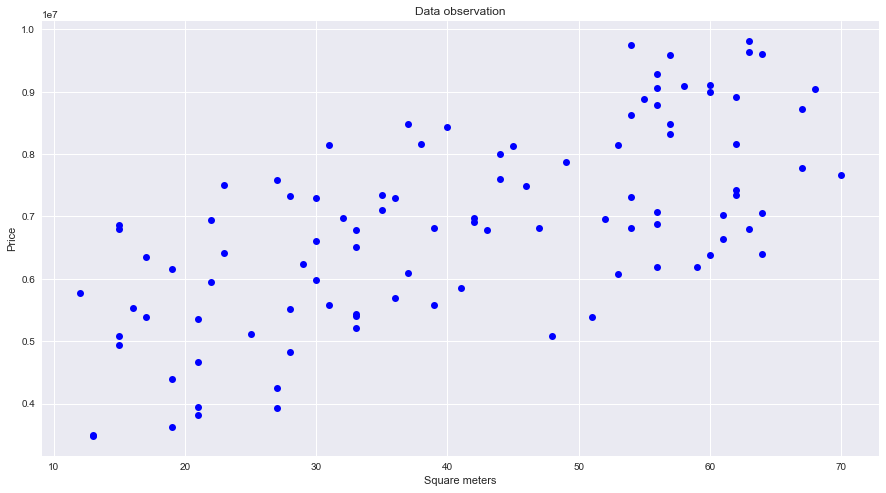

In [10]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo")
plt.xlabel("Square meters")
plt.ylabel("Price")

plt.title("Data observation")

plt.show()

## Splitting data 

In [11]:
# Simultaniously shuffling samples.
X, Y = shuffle(X, Y)

In [12]:
# How many samples for testing.
split_mark = 0.3

# Position we are splitting our data.
split_at = round(len(X) * split_mark)

X_test = X[:split_at]
X = X[split_at:]

Y_test = Y[:split_at]
Y = Y[split_at:]

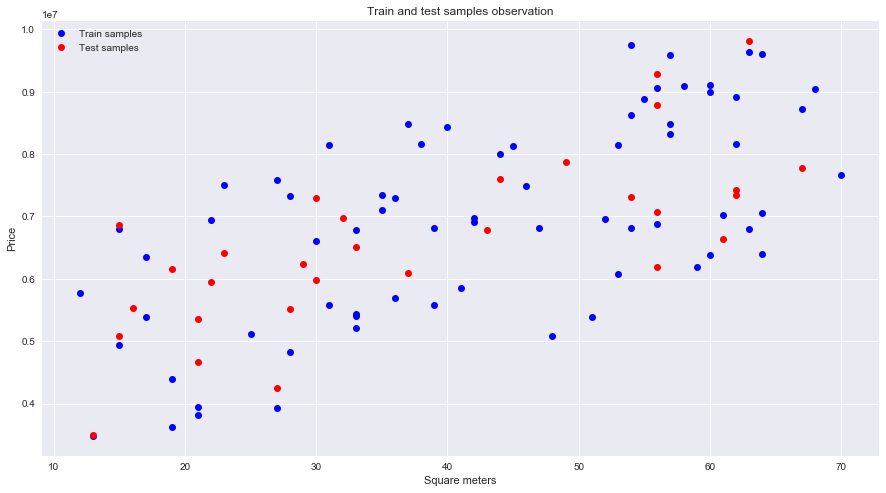

In [13]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo", label="Train samples")
plt.plot(X_test, Y_test, "ro", label="Test samples")
plt.xlabel("Square meters")
plt.ylabel("Price")

plt.title("Train and test samples observation")
plt.legend(loc="upper left")

plt.show()

## Linear regression model 

### Preparing shapes 

In [14]:
# Reshaping vector to column.
X = X.reshape(len(X), 1)
X_test = X_test.reshape(len(X_test), 1)

# Initializing ones column.
ones = np.ones(len(X)).reshape(len(X), 1)

# Merging train column with ones column.
X_matrix = np.hstack([X, ones])
print("X = \n{}\n".format(X_matrix[:5]))

# Counting and confirming Theta.
Theta = linear_regression(X_matrix, Y)
Theta_confirmation = np.linalg.lstsq(X_matrix, Y, rcond=None)[0]
print("Theta (counted manually) = \n{}\n".format(Theta))
print("Theta (counted using numpy) = \n{}\n".format(Theta_confirmation))

# Making predictions on test samples.
Y_predictions = linear_model(X_test, Theta)
print("Test labels and predictions = \n{}".format(list(zip(X_test[:5], Y_predictions[:5]))))

X = 
[[13.  1.]
 [37.  1.]
 [39.  1.]
 [57.  1.]
 [23.  1.]]

Theta (counted manually) = 
[  63955.5800906  4235030.54386127]

Theta (counted using numpy) = 
[  63955.5800906  4235030.54386126]

Test labels and predictions = 
[(array([56]), 7816543.028934776), (array([56]), 7816543.028934776), (array([61]), 8136320.929387768), (array([56]), 7816543.028934776), (array([62]), 8200276.509478366)]


### Building plot 

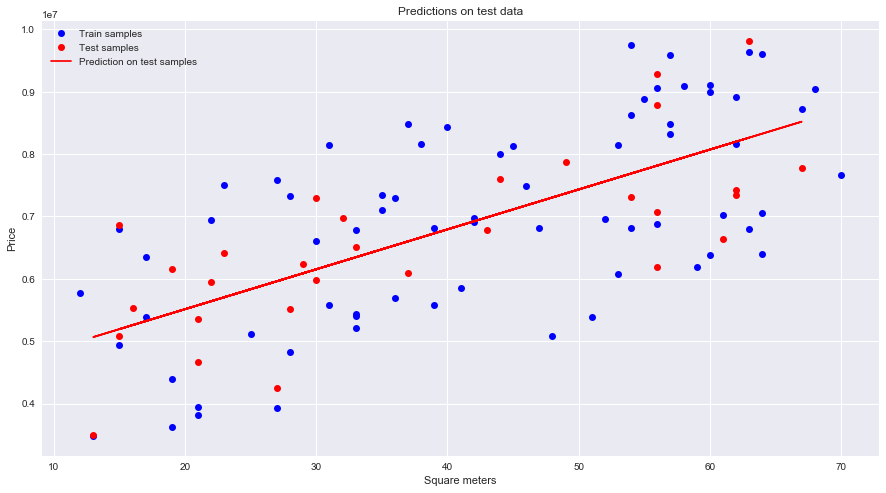

In [15]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo", label="Train samples")
plt.plot(X_test, Y_test, "ro", label="Test samples")
plt.plot(X_test, Y_predictions, "r", label="Prediction on test samples")
plt.xlabel("Square meters")
plt.ylabel("Price")

plt.title("Predictions on test data")
plt.legend(loc="upper left")

plt.show()

In [16]:
linear_squares = create_dataframe(Y_test, Y_predictions, "Linear model --- squares")

## Polynomial regression 

### Preparing results 

In [17]:
# Transforming features vector.
polynomial_features= PolynomialFeatures(degree=15)
X_polynomial = polynomial_features.fit_transform(X)
print("Transformed X: \n{}".format(X_polynomial[:3]))

# Transforming test vector.
X_polynomial_test = polynomial_features.fit_transform(X_test)

Transformed X: 
[[1.00000000e+00 1.30000000e+01 1.69000000e+02 2.19700000e+03
  2.85610000e+04 3.71293000e+05 4.82680900e+06 6.27485170e+07
  8.15730721e+08 1.06044994e+10 1.37858492e+11 1.79216039e+12
  2.32980851e+13 3.02875107e+14 3.93737639e+15 5.11858930e+16]
 [1.00000000e+00 3.70000000e+01 1.36900000e+03 5.06530000e+04
  1.87416100e+06 6.93439570e+07 2.56572641e+09 9.49318771e+10
  3.51247945e+12 1.29961740e+14 4.80858437e+15 1.77917622e+17
  6.58295201e+18 2.43569224e+20 9.01206130e+21 3.33446268e+23]
 [1.00000000e+00 3.90000000e+01 1.52100000e+03 5.93190000e+04
  2.31344100e+06 9.02241990e+07 3.51874376e+09 1.37231007e+11
  5.35200926e+12 2.08728361e+14 8.14040609e+15 3.17475837e+17
  1.23815577e+19 4.82880749e+20 1.88323492e+22 7.34461619e+23]]


In [18]:
# Pushing X to linear model.
model = LinearRegression()
model.fit(X_polynomial, Y)

# Making prediction on test samples.
Y_polynomial_predictions = model.predict(X_polynomial_test)

### Measuring quality 

In [19]:
polynomial_squares = create_dataframe(Y_test, Y_polynomial_predictions, "Polynomial model --- squares")

### Building plot 

In [20]:
# Sort the values of X before line plot.
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_test, Y_polynomial_predictions), key=sort_axis)
X_test, Y_polynomial_predictions = zip(*sorted_zip)

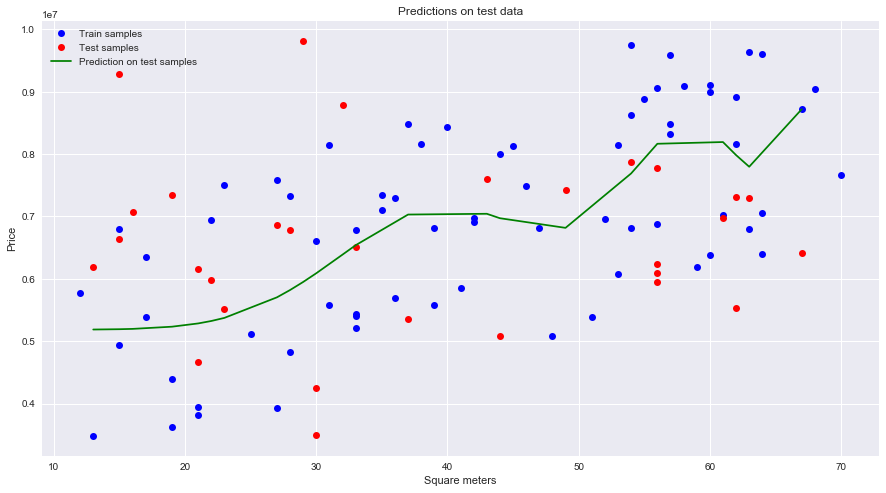

In [21]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo", label="Train samples")
plt.plot(X_test, Y_test, "ro", label="Test samples")
plt.plot(X_test, Y_polynomial_predictions, "g", label="Prediction on test samples")
plt.xlabel("Square meters")
plt.ylabel("Price")

plt.title("Predictions on test data")
plt.legend(loc="upper left")

plt.show()

# Price based on subway distance

## Loading data 

In [22]:
meters_price = data.drop(columns=["SQUARE_METERS"])
display(meters_price)

,METRO_DISTANCE,PRICE
Id,,
601,677,7328400
602,120,9754600
603,1344,6781500
604,1003,6784100
605,591,7296200
...,...,...
696,2073,4826700
697,2120,6800800
698,1411,6517500


In [23]:
# Extracting values and predictions.
X = np.array(meters_price["METRO_DISTANCE"],)
Y = np.array(meters_price["PRICE"])

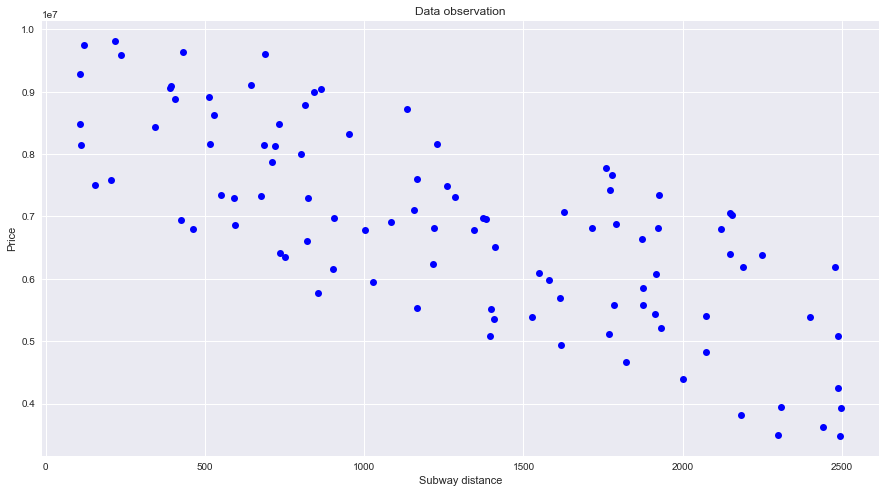

In [24]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo")
plt.xlabel("Subway distance")
plt.ylabel("Price")

plt.title("Data observation")

plt.show()

## Splitting data 

In [25]:
# Simultaniously shuffling samples.
X, Y = shuffle(X, Y)

In [26]:
# How many samples for testing.
split_mark = 0.3

# Position we are splitting our data.
split_at = round(len(X) * split_mark)

X_test = X[:split_at]
X = X[split_at:]

Y_test = Y[:split_at]
Y = Y[split_at:]

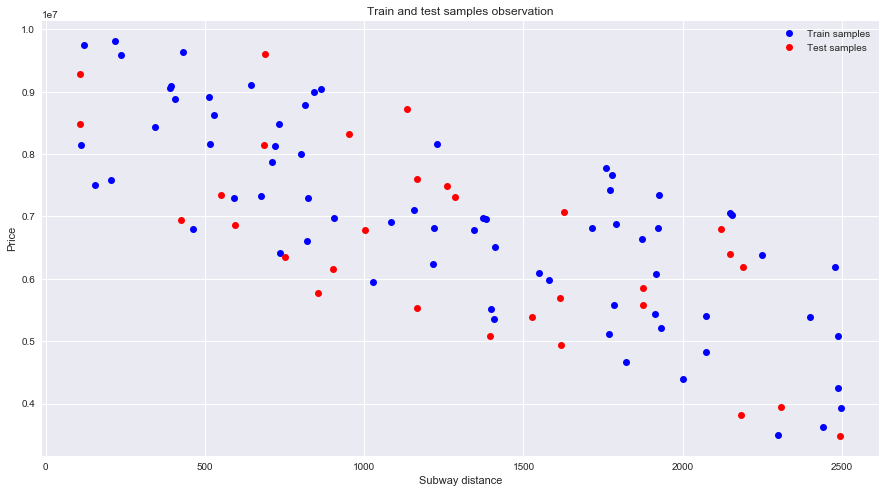

In [27]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo", label="Train samples")
plt.plot(X_test, Y_test, "ro", label="Test samples")
plt.xlabel("Subway distance")
plt.ylabel("Price")

plt.title("Train and test samples observation")
plt.legend(loc="upper right")

plt.show()

## Linear regression model 

### Preparing shapes 

In [28]:
# Reshaping vector to column.
X = X.reshape(len(X), 1)
X_test = X_test.reshape(len(X_test), 1)

# Initializing ones column.
ones = np.ones(len(X)).reshape(len(X), 1)

# Merging train column with ones column.
X_matrix = np.hstack([X, ones])
print("X = \n{}\n".format(X_matrix[:5]))

# Counting and confirming Theta.
Theta = linear_regression(X_matrix, Y)
Theta_confirmation = np.linalg.lstsq(X_matrix, Y, rcond=None)[0]
print("Theta (counted manually) = \n{}\n".format(Theta))
print("Theta (counted using numpy) = \n{}\n".format(Theta_confirmation))

# Making predictions on test samples.
Y_predictions = linear_model(X_test, Theta)
print("Test labels and predictions = \n{}".format(list(zip(X_test[:5], Y_predictions[:5]))))

X = 
[[1.916e+03 1.000e+00]
 [2.073e+03 1.000e+00]
 [2.488e+03 1.000e+00]
 [1.156e+03 1.000e+00]
 [1.110e+02 1.000e+00]]

Theta (counted manually) = 
[-1.69117175e+03  9.13740363e+06]

Theta (counted using numpy) = 
[-1.69117175e+03  9.13740363e+06]

Test labels and predictions = 
[(array([2493]), 4921312.453416791), (array([1003]), 7441158.360501651), (array([752]), 7865642.469681717), (array([686]), 7977259.805163329), (array([1875]), 5966456.594744605)]


### Building plot 

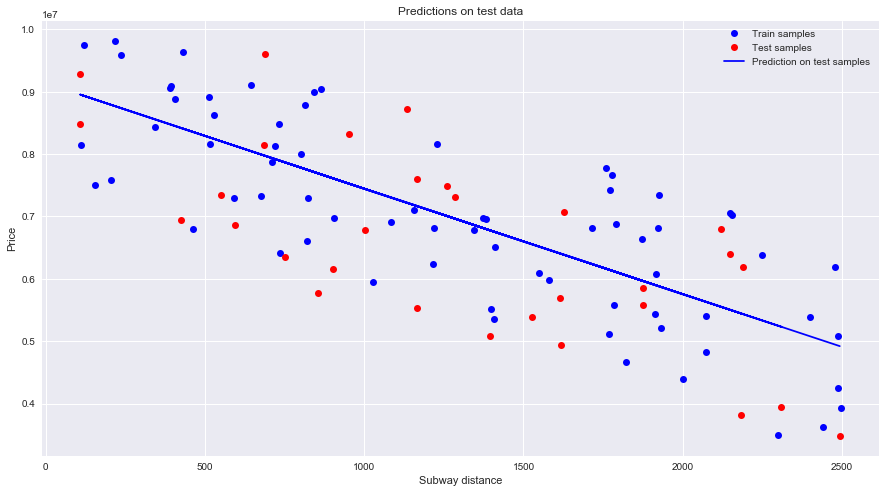

In [29]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo", label="Train samples")
plt.plot(X_test, Y_test, "ro", label="Test samples")
plt.plot(X_test, Y_predictions, "b", label="Prediction on test samples")
plt.xlabel("Subway distance")
plt.ylabel("Price")

plt.title("Predictions on test data")
plt.legend(loc="upper right")

plt.show()

In [30]:
linear_distances = create_dataframe(Y_test, Y_predictions, "Linear model --- distance")

## Polynomial regression 

### Preparing results 

In [31]:
# Transforming features vector.
polynomial_features= PolynomialFeatures(degree=15)
X_polynomial = polynomial_features.fit_transform(X)
print("Transformed X: \n{}".format(X_polynomial[:3]))

# Transforming test vector.
X_polynomial_test = polynomial_features.fit_transform(X_test)

Transformed X: 
[[1.00000000e+00 1.91600000e+03 3.67105600e+06 7.03374330e+09
  1.34766522e+13 2.58212655e+16 4.94735448e+19 9.47913117e+22
  1.81620153e+26 3.47984214e+29 6.66737754e+32 1.27746954e+36
  2.44763163e+39 4.68966220e+42 8.98539278e+45 1.72160126e+49]
 [1.00000000e+00 2.07300000e+03 4.29732900e+06 8.90836302e+09
  1.84670365e+13 3.82821667e+16 7.93589316e+19 1.64511065e+23
  3.41031438e+26 7.06958172e+29 1.46552429e+33 3.03803185e+36
  6.29784003e+39 1.30554224e+43 2.70638906e+46 5.61034452e+49]
 [1.00000000e+00 2.48800000e+03 6.19014400e+06 1.54010783e+10
  3.83178827e+13 9.53348923e+16 2.37193212e+20 5.90136711e+23
  1.46826014e+27 3.65303122e+30 9.08874168e+33 2.26127893e+37
  5.62606198e+40 1.39976422e+44 3.48261338e+47 8.66474209e+50]]


In [32]:
# Pushing X to linear model.
model = LinearRegression()
model.fit(X_polynomial, Y)

# Making prediction on test samples.
Y_polynomial_predictions = model.predict(X_polynomial_test)

### Measuring quality 

In [33]:
polynomial_distances = create_dataframe(Y_test, Y_polynomial_predictions, "Polynomial model --- distances")

### Building plot 

In [34]:
# Sort the values of X before line plot.
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_test, Y_polynomial_predictions), key=sort_axis)
X_test, Y_polynomial_predictions = zip(*sorted_zip)

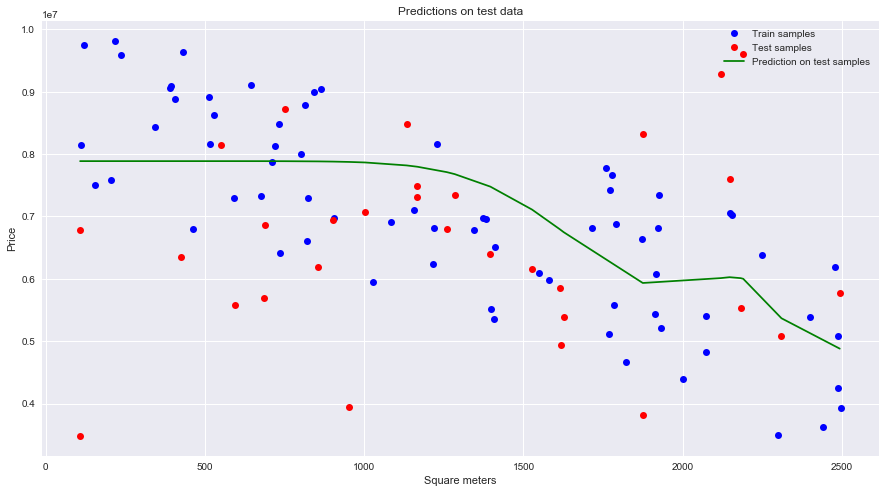

In [35]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(X, Y, "bo", label="Train samples")
plt.plot(X_test, Y_test, "ro", label="Test samples")
plt.plot(X_test, Y_polynomial_predictions, "g", label="Prediction on test samples")
plt.xlabel("Square meters")
plt.ylabel("Price")

plt.title("Predictions on test data")
plt.legend(loc="upper right")

plt.show()

# Price based on both square meters number and subway distance 

## Loading data 

In [36]:
display(data)

,SQUARE_METERS,METRO_DISTANCE,PRICE
Id,,,
601,28,677,7328400
602,54,120,9754600
603,43,1344,6781500
604,33,1003,6784100
605,30,591,7296200
...,...,...,...
696,28,2073,4826700
697,63,2120,6800800
698,33,1411,6517500


In [37]:
# Extracting values and predictions.
X_1 = np.array(data["SQUARE_METERS"])
X_2 = np.array(data["METRO_DISTANCE"])
Y = np.array(data["PRICE"])

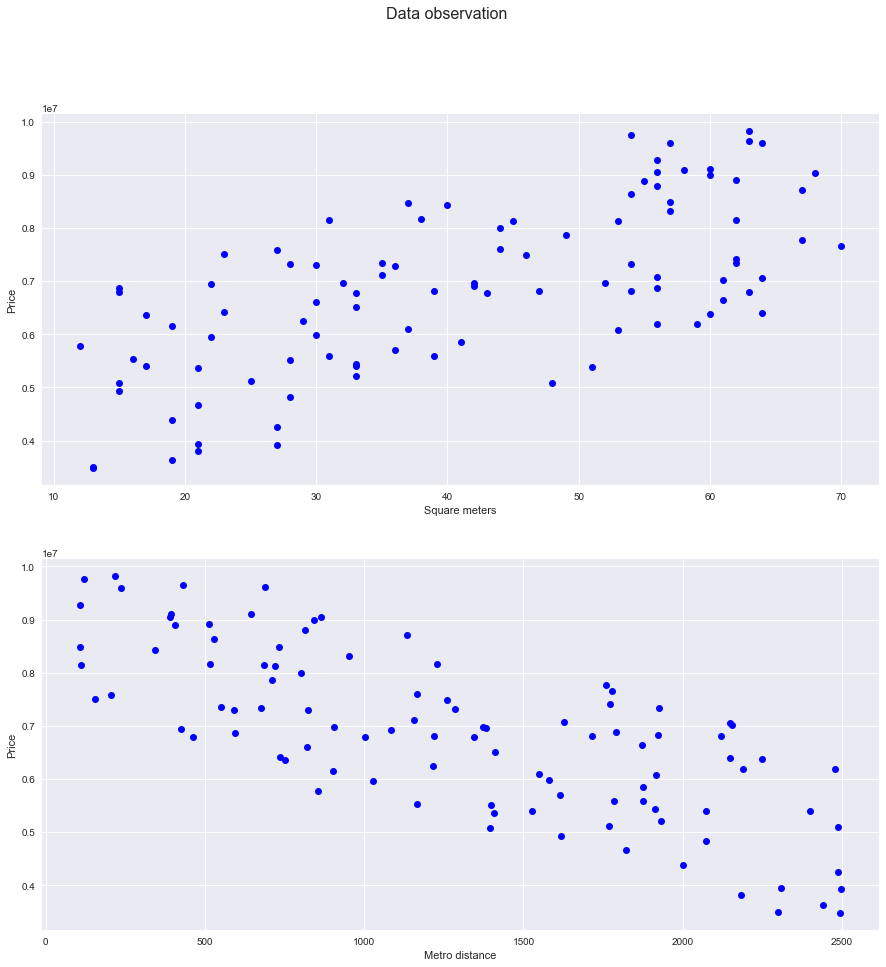

In [38]:
# Building plot.

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax[0].plot(X_1, Y, "bo")
ax[0].set(xlabel='Square meters', ylabel='Price')

ax[1].plot(X_2, Y, "bo")
ax[1].set(xlabel='Metro distance', ylabel='Price')

fig.suptitle("Data observation", fontsize=16)

plt.show()

## Splitting data 

In [39]:
# Simultaniously shuffling samples.
X_1, X_2, Y = shuffle(X_1, X_2, Y)

In [40]:
# How many samples for testing.
split_mark = 0.3

# Position we are splitting our data.
split_at = round(len(X_1) * split_mark)

X_1_test = X_1[:split_at]
X_1 = X_1[split_at:]

X_2_test = X_2[:split_at]
X_2 = X_2[split_at:]

Y_test = Y[:split_at]
Y = Y[split_at:]

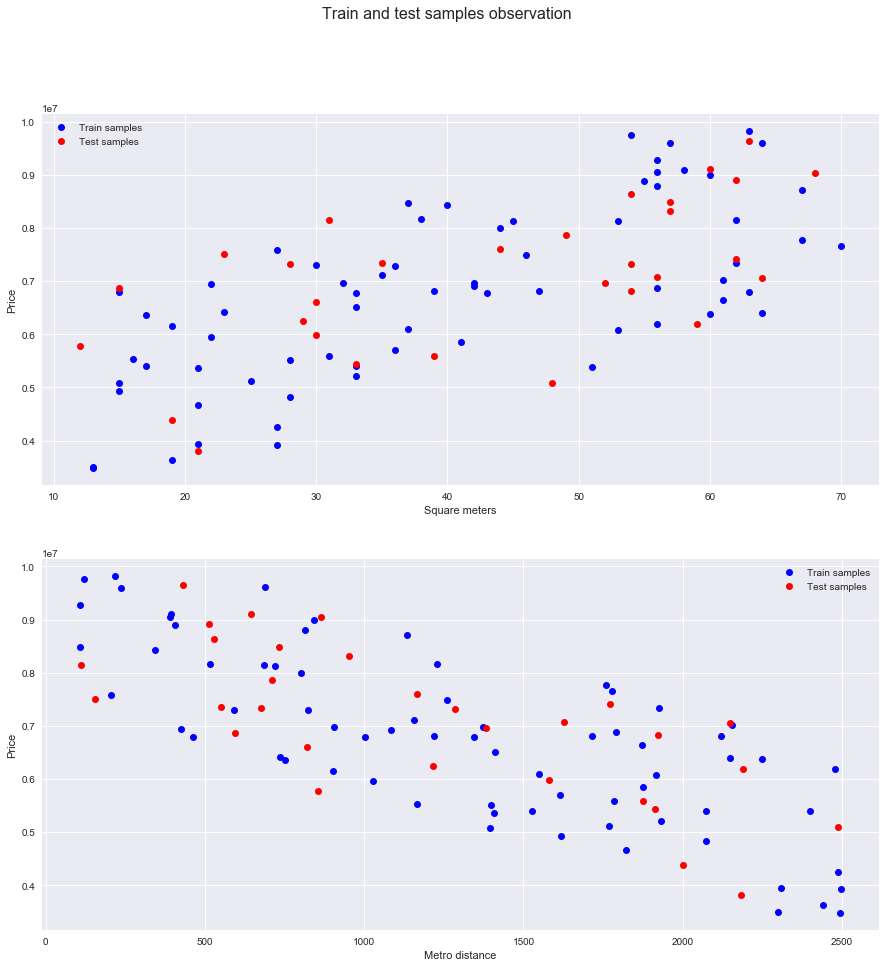

In [41]:
# Building plot.

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax[0].plot(X_1, Y, "bo", label="Train samples")
ax[0].plot(X_1_test, Y_test, "ro", label="Test samples")
ax[0].set(xlabel='Square meters', ylabel='Price')
ax[0].legend(loc="upper left")

ax[1].plot(X_2, Y, "bo", label="Train samples")
ax[1].plot(X_2_test, Y_test, "ro", label="Test samples")
ax[1].set(xlabel='Metro distance', ylabel='Price')
ax[1].legend(loc="upper right")

fig.suptitle("Train and test samples observation", fontsize=16)

plt.show()

## Linear regression model 

### Preparing shapes 

In [42]:
# Initialining matrixes.
X_matrix = np.array([X_1, X_2]).T
X_test_matrix = np.array([X_1_test, X_2_test]).T

# Initializing ones column.
ones = np.ones(len(X_1)).reshape(70, 1)

# Merging train matrix with ones vector.
X_matrix = np.hstack([X_matrix, ones])
print("X = \n{}\n".format(X_matrix[:5]))

# Counting and confirming Theta.
Theta = linear_regression(X_matrix, Y)
Theta_confirmation = np.linalg.lstsq(X_matrix, Y, rcond=None)[0]
print("Theta (counted manually) = \n{}\n".format(Theta))
print("Theta (counted using numpy) = \n{}\n".format(Theta_confirmation))

# Making predictions on test samples.
Y_predictions = linear_model(X_test_matrix, Theta)
print("Test labels and predictions = \n{}".format(list(zip(X_test_matrix[:5], Y_predictions[:5]))))

X = 
[[2.500e+01 1.768e+03 1.000e+00]
 [1.500e+01 1.396e+03 1.000e+00]
 [5.600e+01 2.478e+03 1.000e+00]
 [3.300e+01 1.933e+03 1.000e+00]
 [6.000e+01 2.250e+03 1.000e+00]]

Theta (counted manually) = 
[ 5.93312463e+04 -1.60399544e+03  6.48459366e+06]

Theta (counted using numpy) = 
[ 5.93312463e+04 -1.60399544e+03  6.48459366e+06]

Test labels and predictions = 
[(array([  21, 2182]), 4230631.785720572), (array([ 57, 731]), 8693954.035552276), (array([  64, 2149]), 6834807.225985655), (array([  29, 1216]), 6254741.350943876), (array([ 15, 593]), 6423393.061790273)]


### Building plot 

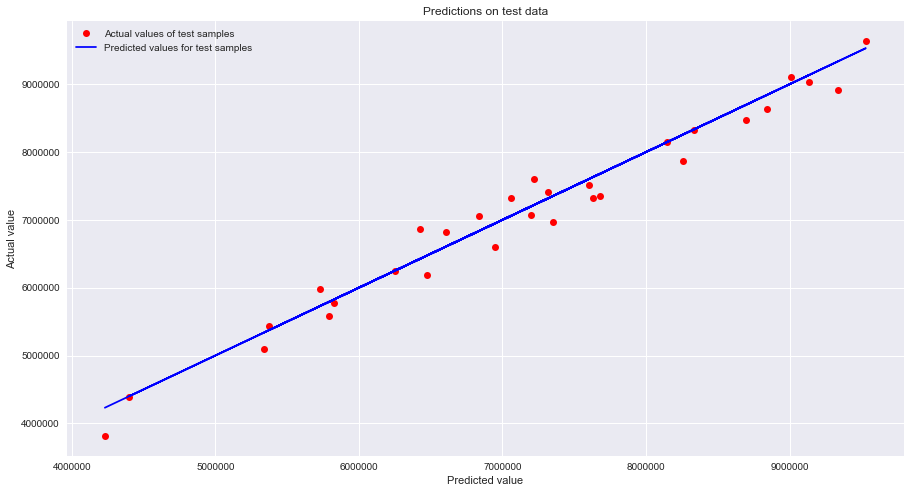

In [43]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(Y_predictions, Y_test, "ro", label="Actual values of test samples")
plt.plot(Y_predictions, Y_predictions, "b", label="Predicted values for test samples")
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.legend(loc="upper left")

plt.title("Predictions on test data")

plt.show()

In [44]:
linear_both = create_dataframe(Y_test, Y_predictions, "Linear model --- both")

## Polynomial regression 

### Preparing results 

In [45]:
X_matrix = np.array([X_1, X_2]).T
X_test_matrix = np.array([X_1_test, X_2_test]).T

# Transforming features vector.
polynomial_features= PolynomialFeatures(degree=5)
X_polynomial = polynomial_features.fit_transform(X_matrix)
print("Transformed X: \n{}".format(X_polynomial[:3]))

# Transforming test vector.
X_polynomial_test = polynomial_features.fit_transform(X_test_matrix)

Transformed X: 
[[1.00000000e+00 2.50000000e+01 1.76800000e+03 6.25000000e+02
  4.42000000e+04 3.12582400e+06 1.56250000e+04 1.10500000e+06
  7.81456000e+07 5.52645683e+09 3.90625000e+05 2.76250000e+07
  1.95364000e+09 1.38161421e+11 9.77077568e+12 9.76562500e+06
  6.90625000e+08 4.88410000e+10 3.45403552e+12 2.44269392e+14
  1.72747314e+16]
 [1.00000000e+00 1.50000000e+01 1.39600000e+03 2.25000000e+02
  2.09400000e+04 1.94881600e+06 3.37500000e+03 3.14100000e+05
  2.92322400e+07 2.72054714e+09 5.06250000e+04 4.71150000e+06
  4.38483600e+08 4.08082070e+10 3.79788380e+12 7.59375000e+05
  7.06725000e+07 6.57725400e+09 6.12123106e+11 5.69682570e+13
  5.30184579e+15]
 [1.00000000e+00 5.60000000e+01 2.47800000e+03 3.13600000e+03
  1.38768000e+05 6.14048400e+06 1.75616000e+05 7.77100800e+06
  3.43867104e+08 1.52161194e+10 9.83449600e+06 4.35176448e+08
  1.92565578e+10 8.52102684e+11 3.77055438e+13 5.50731776e+08
  2.43698811e+10 1.07836724e+12 4.77177503e+13 2.11151045e+15
  9.34343374e+16]]

In [46]:
# Pushing X to linear model.
model = LinearRegression()
model.fit(X_polynomial, Y)

# Making prediction on test samples.
Y_polynomial_predictions = model.predict(X_polynomial_test)

### Building plot 

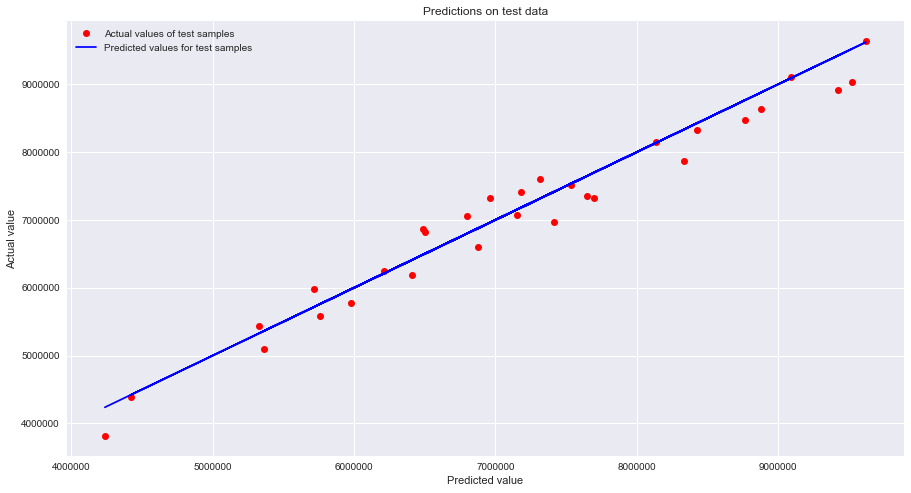

In [47]:
# Building plot.
plt.figure(figsize=(15,8))

plt.plot(Y_polynomial_predictions, Y_test, "ro", label="Actual values of test samples")
plt.plot(Y_polynomial_predictions, Y_polynomial_predictions, "b", label="Predicted values for test samples")
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.legend(loc="upper left")

plt.title("Predictions on test data")

plt.show()

In [48]:
polynomial_both = create_dataframe(Y_test, Y_polynomial_predictions, "Polynomial model --- both")

# Results 

In [49]:
# Merging dataframes together
frames = [linear_distances, linear_squares, linear_both, polynomial_distances, polynomial_squares, polynomial_both]
result = pd.concat(frames)
result.set_index('method name', inplace=True)

In [50]:
display(result)

,squared error,mae,mse,rmse,mpe,mape,ad,mad,cd,tayle
method name,,,,,,,,,,
Linear model --- distance,3.900952e+13,1014219.61,1.300317e+12,1140314.61,-9.30,17.34,30426588.37,1014219.61,0.43,0.12
Linear model --- squares,2.619681e+13,780636.25,8.732270e+11,934466.15,-2.88,12.49,23419087.38,780636.25,0.53,0.10
Linear model --- both,1.891043e+12,209889.55,6.303475e+10,251067.23,-1.12,3.13,6296686.46,209889.55,0.97,0.02
Polynomial model --- distances,4.796818e+13,1049229.81,1.598939e+12,1264491.75,-12.84,18.43,31476894.45,1049229.81,0.30,0.13
Polynomial model --- squares,3.001987e+13,828344.02,1.000662e+12,1000331.14,-2.15,13.12,24850320.71,828344.02,0.46,0.10
Polynomial model --- both,2.410783e+12,239580.47,8.035942e+10,283477.37,-1.32,3.53,7187414.17,239580.47,0.96,0.03
